In [1]:
# Import necessary libraries
import pandas as pd  # For handling data in DataFrame format

#Natural language processing libraries
import nltk  # For natural language processing tasks(i.e A library for working with human language data)
from nltk.corpus import stopwords  # To access stopwords for text preprocessing
from nltk.stem import WordNetLemmatizer # To reduce words to their base or root form

# Download the list of stopwords from NLTK
nltk.download('stopwords') # Download stopwords data
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Load datasets
train_data = pd.read_csv('/content/train.csv')  # Read the CSV file into a DataFrame
train_data = train_data[['text', 'target']] #select column

test_data = pd.read_csv('/content/train.csv')
# View the first 4 rows of the dataset to understand its structure
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Check the overall structure and info about the dataset
train_data.info()  # To get information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


# Data Cleaning and Preprocessing

In [4]:
# Check for missing values
train_data.isnull().sum()

,0
text,0
target,0


In [5]:
#Check for duplicate record
train_data.duplicated().sum()

92

In [6]:
# Remove duplicate entries to avoid training the model on repetitive data
train_data.drop_duplicates(keep='first', inplace=True) # keep = 'first' means keeping the first occurence before removing duplicates

In [7]:
# Confirm if there are still duplicates
train_data.duplicated().sum()

0

In [8]:
# Check the updated shape of the dataset after removing duplicates
train_data.shape

(7521, 2)

# Exploroatory Data analysis (EDA) & Text Preprocessing

In [9]:
train_data.describe()  # Get summary statistics for numerical columns

,target
count,7521.000000
mean,0.426273
std,0.494567
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
# Check unique values in the 'target' column
print(train_data['target'].unique())

[1 0]


# Disaster vs Non-Disaster Tweets

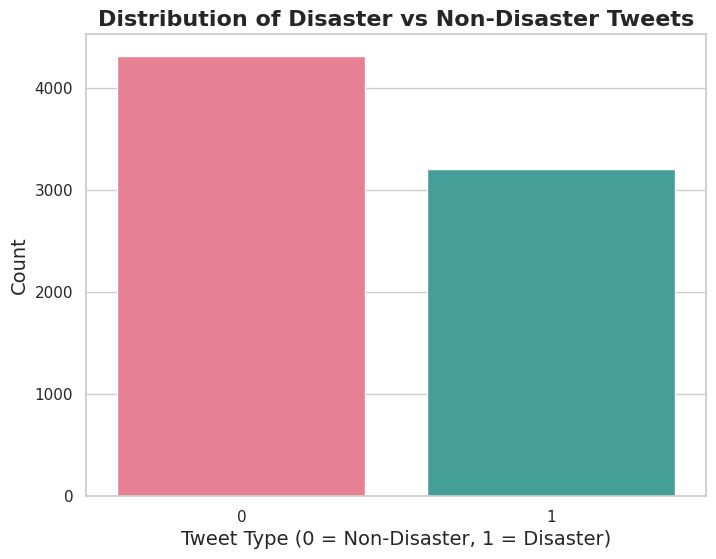

In [12]:
# Import the required library for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style='whitegrid')

# Plot label distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='target', data=train_data, palette='husl', hue='target', legend=False)

# Customize the title and labels
plt.title('Distribution of Disaster vs Non-Disaster Tweets', fontsize=16, fontweight='bold')
plt.xlabel('Tweet Type (0 = Non-Disaster, 1 = Disaster)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Show the plot
plt.show()

# #The above shows that the data is imbalanced, one of the reasons why F1 score is used for evaluation

# Tweet Length Analysis

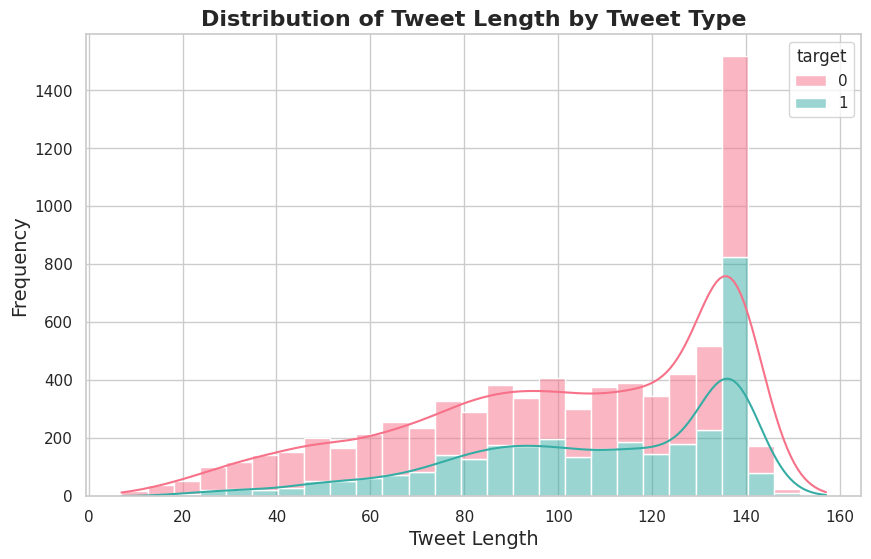

In [13]:
# Copy the dataframe to avoid changing the original one
train_data_copy = train_data.copy()

# Calculate the length of each tweets
train_data_copy['Tweet_length'] = train_data_copy['text'].str.len()

# Set plot style
sns.set(style='whitegrid')

# Create a figure and plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))

# Plot the distribution of tweet lengths for 0 and 1
sns.histplot(data=train_data_copy, x='Tweet_length', hue='target', multiple='stack', palette='husl', kde=True)

# Customize the title and label
plt.xlabel('Tweet Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Tweet Length by Tweet Type', fontsize=16, fontweight='bold')

# Show the plot
plt.show()


# Text Preprocessing

In [14]:
#Import preprocessing libraries
import re  # For regular expression operations(i.e removing unwanted characters)

# Define a function to clean email messages
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters (punctuation)
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+[a-z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text

# Apply the preprocessing function to all email messages
train_data_copy['text'] = train_data_copy['text'].apply(preprocess_text)

#lemmatization
lemmatizer = WordNetLemmatizer()
train_data_copy['text'] = train_data_copy['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
train_data = train_data_copy

# Word Clouds

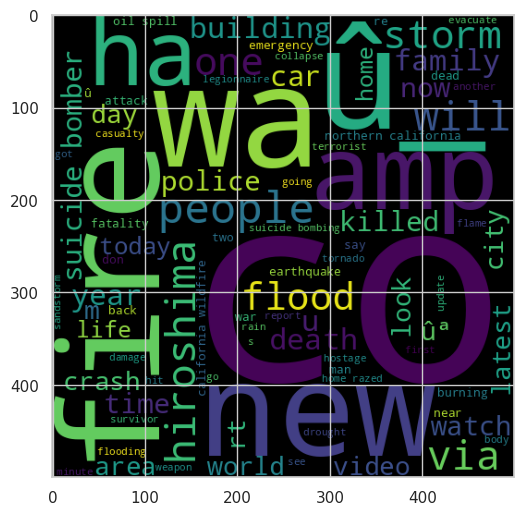

In [15]:
#Create a word cloud for Disaster Tweets

#import wordcloud library
from wordcloud import WordCloud

wordcloud = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
spam_wordcloud = wordcloud.generate(train_data[train_data['target'] == 1]['text'].str.cat(sep = " "))
plt.figure(figsize = (14,6))
plt.imshow(spam_wordcloud)
plt.show()

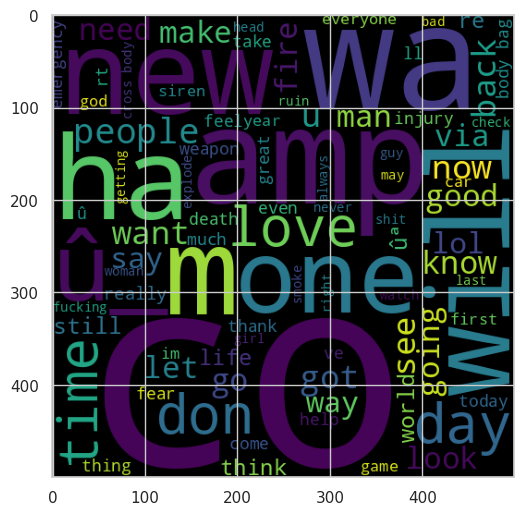

In [16]:
#Create a word cloud for Non-disaster tweets

wordcloud = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
ham_wordcloud = wordcloud.generate(train_data[train_data['target'] == 0]['text'].str.cat(sep = " "))
plt.figure(figsize = (14,6))
plt.imshow(ham_wordcloud)
plt.show()

# Model Building and Training

In [17]:
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
#Train-test split
X = train_data['text']
y = train_data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Transform the training and testing data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import PassiveAggressiveClassifier



# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'Passive Aggressive Classifier': PassiveAggressiveClassifier()


}

In [21]:
# Train each model and store the predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    predictions[name] = model.predict(X_val_tfidf)

In [22]:
# Train each model and store the predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    predictions[name] = model.predict(X_val_tfidf)

In [23]:
# Make predictions for each model
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_val_tfidf)

# Model Evaluation

In [24]:
# Evaluate each model by displaying f1 score
from sklearn.metrics import f1_score

# Collect accuracy scores and classification reports
results = {}
for name, y_pred in predictions.items():
    f1 = f1_score(y_val, y_pred)

    results[name] = {
        'f1_score': f1
    }


# Display results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"f1_score: {result['f1_score']:.4f}")
    print(' ')

Model: Logistic Regression
f1_score: 0.7324
 
Model: Naive Bayes
f1_score: 0.7467
 
Model: Random Forest
f1_score: 0.7050
 
Model: Support Vector Machine
f1_score: 0.7292
 
Model: Gradient Boosting
f1_score: 0.6494
 
Model: K-Nearest Neighbors
f1_score: 0.3477
 
Model: Decision Tree
f1_score: 0.6365
 
Model: Neural Network
f1_score: 0.6975
 
Model: Extra Trees Classifier
f1_score: 0.7394
 
Model: Passive Aggressive Classifier
f1_score: 0.6872
 


# Train with the best Model

In [25]:
#Train the best model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

#  Submission

In [26]:
#Prepare submission
test_data['text'] = test_data['text'].apply(preprocess_text)
test_vec = tfidf.transform(test_data['text'])
test_pred = model.predict(test_vec)

In [27]:
#submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_pred})
submission.to_csv('submission.csv', index=False)